### End-to-end SSL stepcounter training with OxWalk

This notebook trains the stepcounter that was used in:

Small SR, Chan S, Walmsley R, et al. (2023)
[Development and Validation of a Machine Learning Wrist-worn Step Detection Algorithm with Deployment in the UK Biobank](https://www.medrxiv.org/content/10.1101/2023.02.20.23285750v1).
medRxiv. DOI: 10.1101/2023.02.20.23285750

This notebook has been modified to run on Dr. Keadle's Cal Poly ACT24 data.

Original notebook can be found [here](https://github.com/OxWearables/stepcount/blob/main/train-ssl.ipynb).

## Imports

In [38]:
import re
import glob
import os
import numpy as np
import pandas as pd
import pathlib
import torch
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

Check torch version and to see if GPU acceleration is available.

This notebook was originally run on torch version 2.2.2+cu121, with GPU acceleration.

In [39]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

2.2.2+cu121
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Data processing

Below are functions to load the data, adapted from the original functions provided by UK Biobank. Requires the following files:
- ACT24_Apr2024 directory, with ACT24_###_#_SSL.csv files created by the DATA 2024 team. ### is the id, # is the observation.

In [40]:
DATA_DIR = 'ACT24_Apr2024'  # location of data (the ACT24_###_#_SSL.csv files should be in this folder)
DATAFILES = os.path.join(DATA_DIR, 'ACT24_*.csv')
OUT_DIR = './data/act24_80hz/'  # output location of the processed dataset
WINDOW_SEC = 10  # seconds
STEP_THRESHOLD = 4  # how many steps per window to consider a step (equal or more). This is not used in this notebook but is kept as a placeholder

DEVICE_HZ = 80  # original sample rate Hz
RESAMPLE_HZ = 30  # Hz
WINDOW_OVERLAP_SEC = 0  # seconds
WINDOW_LEN = int(DEVICE_HZ * WINDOW_SEC)  # device ticks
WINDOW_OVERLAP_LEN = int(DEVICE_HZ * WINDOW_OVERLAP_SEC)  # device ticks
WINDOW_STEP_LEN = WINDOW_LEN - WINDOW_OVERLAP_LEN  # device ticks
WINDOW_TOL = 0.01  # 1%


def resize(x, length, axis=1):
    """Resize the temporal length using linear interpolation.
    X must be of shape (N,M,C) (channels last) or (N,C,M) (channels first),
    where N is the batch size, M is the temporal length, and C is the number
    of channels.
    If X is channels-last, use axis=1 (default).
    If X is channels-first, use axis=2.
    """
    from scipy.interpolate import interp1d

    length_orig = x.shape[axis]
    t_orig = np.linspace(0, 1, length_orig, endpoint=True)
    t_new = np.linspace(0, 1, length, endpoint=True)
    x = interp1d(t_orig, x, kind="linear", axis=axis, assume_sorted=True)(
        t_new
    )
    return x


def is_good_quality(w):
    """ Window quality check """

    if w.isna().any().any():
        return False

    if len(w) != WINDOW_LEN:
        return False

    w_start, w_end = w.index[0], w.index[-1]
    w_duration = w_end - w_start
    target_duration = pd.Timedelta(WINDOW_SEC, 's')
    if np.abs(w_duration - target_duration) > WINDOW_TOL * target_duration:
        return False

    return True


def make(datafile):
    X, Y, T, P, = [], [], [], []
    y_step = []

    data = pd.read_csv(datafile, parse_dates=['timestamp'], index_col='timestamp')

    p = re.search(r'(ACT24_\d{3}_\d{1})', datafile, flags=re.IGNORECASE).group()

    for i in range(0, len(data), WINDOW_STEP_LEN):
        w = data.iloc[i:i + WINDOW_LEN]
        postures = w['posture'].mode()

        if not is_good_quality(w) or "private/not coded" in list(postures):
            continue

        t = w.index[0].to_datetime64()
        x = w[['x', 'y', 'z']].values
        posture = postures.sample(n=1).iloc[0]
        # count = int(w['annotation'].sum())
        count = int(w['step'].sum())
        y = posture

        X.append(x)
        Y.append(y)
        T.append(t)
        P.append(p)
        y_step.append(count)

    X = np.asarray(X)
    Y = np.asarray(Y)
    T = np.asarray(T)
    P = np.asarray(P)
    y_step = np.asarray(y_step)

    if DEVICE_HZ != RESAMPLE_HZ:
        X = resize(X, int(RESAMPLE_HZ * WINDOW_SEC))

    return X, Y, T, P, y_step

Convert the raw data into 10s windowed data X at 30Hz, with step count annotations Y_step and group labels groups. A categorical array Y is also generated. Save to disk for later reuse. **This means that the code in this section only needs to be run once!**

In [41]:
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

with Parallel(n_jobs=4, prefer="threads") as parallel:
    results = parallel(delayed(make)(datafile) for datafile in tqdm(glob.glob(DATAFILES)))

x, y, t, p, y_step = zip(*results)

X = np.vstack(x)  # data windows
Y = np.hstack(y)  # binary labels walk/notwalk (based on Y_step >= STEP_THRESHOLD)
Y_step = np.hstack(y_step)  # step counts per window
T = np.hstack(t)  # timestamps
groups = np.hstack(p)  # group ids

np.save(os.path.join(OUT_DIR, 'X'), X)
np.save(os.path.join(OUT_DIR, 'Y'), Y)
np.save(os.path.join(OUT_DIR, 'time'), T)
np.save(os.path.join(OUT_DIR, 'groups'), groups)
np.save(os.path.join(OUT_DIR, 'Y_step'), Y_step)

print(f"Saved in {OUT_DIR}")
print("X shape:", X.shape)
print("Y distribution:")
print(pd.Series(Y).value_counts())

100%|██████████| 32/32 [01:46<00:00,  3.33s/it]


Saved in ./data/act24_80hz/
X shape: (32640, 300, 3)
Y distribution:
sitting                 16326
stand                    7563
walk                     3151
stand and move           2899
walk with load            782
lying                     667
kneeling/ squatting       326
stretching                294
bike                      262
ascend stairs             172
muscle strengthening       96
descend stairs             59
other sport movement       42
running                     1
Name: count, dtype: int64


## Load data from disk

The oxwearables activity classifier can only use numeric input, so below we create mappings to convert the posture categorical labels to numbers and back.

In [42]:
posture_to_num = {"sitting": 0, "stand": 1, "walk": 2, "stand and move": 3, "walk with load": 4, "lying": 5, "kneeling/ squatting": 6, "stretching": 7, "bike": 8, "ascend stairs": 9, "muscle strengthening": 10, "descend stairs": 11, "other sport movement": 12, "running": 13}
num_to_posture = {0: "sitting", 1: "stand", 2: "walk", 3: "stand and move", 4: "walk with load", 5: "lying", 6: "kneeling/ squatting", 7: "stretching", 8: "bike", 9: "ascend stairs", 10: "muscle strengthening", 11: "descend stairs", 12: "other sport movement", 13: "running"}

Load data from disk. This is what was saved in the previous section. Note that the postures have been converted to numbers.

In [43]:
path = './data/act24_80hz/'

X = np.load(path + 'X.npy')
Y_step = np.load(path + 'Y_step.npy')
Y = pd.Series(np.load(path + 'Y.npy')).map(posture_to_num).to_numpy()
groups = np.load(path + 'groups.npy')
T = np.load(path + 'time.npy')

In [44]:
pd.Series(Y).value_counts(normalize=True)

0     0.500184
1     0.231710
2     0.096538
3     0.088817
4     0.023958
5     0.020435
6     0.009988
7     0.009007
8     0.008027
9     0.005270
10    0.002941
11    0.001808
12    0.001287
13    0.000031
Name: proportion, dtype: float64

## Posture classifier NN code

Below is the neural network that classifies posture, modified to classify more postures as they appear in the ACT24 dataset.

The stepcount dependencies can be downloaded here, if there are any errors in loading the package with pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [45]:
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn.model_selection import GroupShuffleSplit
from stepcount import hmm_utils
from stepcount import sslmodel
from torch.utils.data import DataLoader

from sklearn.utils.class_weight import compute_class_weight

class WalkDetectorSSL:
    def __init__(
            self,
            device='cpu',
            batch_size=100,
            weights_path='state_dict.pt',
            repo_tag='v1.0.0',
            hmm_params=None,
            verbose=False,
    ):
        self.device = device
        self.weights_path = weights_path
        self.repo_tag = repo_tag
        self.batch_size = batch_size
        self.state_dict = None

        self.verbose = verbose

        hmm_params = hmm_params or dict()
        self.hmms = hmm_utils.HMMSmoother(**hmm_params)

    def fit(self, X, Y, groups=None):
        sslmodel.verbose = self.verbose

        if self.verbose:
            print('Training SSL')

        # prepare training and validation sets
        folds = GroupShuffleSplit(
            1, test_size=0.2, random_state=41
        ).split(X, Y, groups=groups)
        train_idx, val_idx = next(folds)

        x_train = X[train_idx]
        x_val = X[val_idx]

        y_train = Y[train_idx]
        y_val = Y[val_idx]

        group_train = groups[train_idx]
        group_val = groups[val_idx]

        train_dataset = sslmodel.NormalDataset(x_train, y_train, pid=group_train, name="training", augmentation=True)
        val_dataset = sslmodel.NormalDataset(x_val, y_val, pid=group_val, name="validation")

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=1,
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=1,
        )

        # balancing to 90% notwalk, 10% walk
        class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y).tolist()

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=True, class_num=len(np.unique(Y)))
        model.to(self.device)

        sslmodel.train(model, train_loader, val_loader, self.device,
                       class_weights, weights_path=self.weights_path)
        model.load_state_dict(torch.load(self.weights_path, self.device))

        if self.verbose:
            print('Training HMM')

        # train HMM with predictions of the validation set
        y_val, y_val_pred, group_val = sslmodel.predict(model, val_loader,
                                                        self.device,
                                                        output_logits=True)
        y_val_pred_sf = softmax(y_val_pred, axis=1)

        self.hmms.fit(y_val_pred_sf, y_val, groups=group_val)

        # move model to cpu to get a device-less state dict (prevents device conflicts when loading on cpu/gpu later)
        model.to('cpu')
        self.state_dict = model.state_dict()

        return self

    def predict(self, X, groups=None):
        sslmodel.verbose = self.verbose

        dataset = sslmodel.NormalDataset(X, name='prediction')
        dataloader = DataLoader(
            dataset,
            batch_size=512,
            shuffle=False,
            num_workers=0,
        )

        model = sslmodel.get_sslnet(tag=self.repo_tag, pretrained=False, class_num=14)
        model.load_state_dict(self.state_dict)
        model.to(self.device)

        _, y_pred, _ = sslmodel.predict(model, dataloader, self.device, output_logits=False)

        y_pred = self.hmms.predict(y_pred, groups=groups)

        return y_pred

## Train posture classifier

The code below will save the model to the disk. **Don't run more than once!**

In [46]:
wd = WalkDetectorSSL(
    device='cuda' if torch.cuda.is_available() else 'cpu',
    batch_size=512,
    verbose=True
)
wd.fit(X, Y, groups)
joblib.dump(wd, 'keadle2.joblib.lzma', compress=('lzma', 3))

Training SSL
Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
131 Weights loaded


100%|██████████| 50/50 [01:44<00:00,  2.08s/it]


Validation loss decreased (inf --> 3.910820). Saving model ...
[  0/100] | train_loss: 2.580 | train_acc: 0.319 | val_loss: 3.911 | val_acc: 0.33


100%|██████████| 50/50 [01:18<00:00,  1.58s/it]


Validation loss decreased (3.910820 --> 3.704713). Saving model ...
[  1/100] | train_loss: 0.957 | train_acc: 0.457 | val_loss: 3.705 | val_acc: 0.27


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Validation loss decreased (3.704713 --> 3.406044). Saving model ...
[  2/100] | train_loss: 0.744 | train_acc: 0.496 | val_loss: 3.406 | val_acc: 0.40


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


EarlyStopping counter: 1/5
[  3/100] | train_loss: 0.606 | train_acc: 0.547 | val_loss: 3.598 | val_acc: 0.42


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


EarlyStopping counter: 2/5
[  4/100] | train_loss: 0.531 | train_acc: 0.576 | val_loss: 3.700 | val_acc: 0.46


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


EarlyStopping counter: 3/5
[  5/100] | train_loss: 0.469 | train_acc: 0.610 | val_loss: 3.699 | val_acc: 0.50


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


EarlyStopping counter: 4/5
[  6/100] | train_loss: 0.399 | train_acc: 0.640 | val_loss: 3.729 | val_acc: 0.49


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]


EarlyStopping counter: 5/5
[  7/100] | train_loss: 0.362 | train_acc: 0.666 | val_loss: 3.836 | val_acc: 0.53
Early stopping
SSLNet weights saved to state_dict.pt
Training HMM
Classifying windows...


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


['keadle2.joblib.lzma']

In [47]:
Y_hat = wd.predict(X, groups)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 64/64 [00:06<00:00,  9.63it/s]


Observed posture distribution:

In [48]:
obs = pd.Series(Y).map(num_to_posture)
obs.value_counts()

sitting                 16326
stand                    7563
walk                     3151
stand and move           2899
walk with load            782
lying                     667
kneeling/ squatting       326
stretching                294
bike                      262
ascend stairs             172
muscle strengthening       96
descend stairs             59
other sport movement       42
running                     1
Name: count, dtype: int64

Predicted posture distribution:

In [49]:
pred = pd.Series(Y_hat).map(num_to_posture)
pred.value_counts()

sitting                 16732
stand and move           3792
stand                    3272
walk                     3039
stretching               2765
lying                    1938
walk with load            821
ascend stairs             155
muscle strengthening       60
descend stairs             44
kneeling/ squatting        22
Name: count, dtype: int64

Error (in # of epochs classified) by posture:

In [50]:
results = pd.concat([obs.value_counts(), pred.value_counts()], axis=1).fillna(0).astype(int)
results.columns = ["obs", "pred"]
results["error"] = np.abs(results["obs"] - results["pred"])
results["perror"] = np.round(results["error"] / results["obs"], 4) * 100
results

,obs,pred,error,perror
sitting,16326,16732,406,2.49
stand,7563,3272,4291,56.74
walk,3151,3039,112,3.55
stand and move,2899,3792,893,30.80
walk with load,782,821,39,4.99
lying,667,1938,1271,190.55
kneeling/ squatting,326,22,304,93.25
stretching,294,2765,2471,840.48
bike,262,0,262,100.00
ascend stairs,172,155,17,9.88


Posture classifier confusion matrix:

In [51]:
Y_cat = np.unique(np.load(path+'Y.npy'))

In [52]:
conf = pd.crosstab(pd.Categorical(obs, categories=Y_cat), pd.Categorical(pred, categories=Y_cat), dropna=False)
conf.index.name = "obs"
conf.columns.name = "pred"
conf

pred,ascend stairs,bike,descend stairs,kneeling/ squatting,lying,muscle strengthening,other sport movement,running,sitting,stand,stand and move,stretching,walk,walk with load
obs,,,,,,,,,,,,,,
ascend stairs,141,0,0,0,0,0,0,0,2,2,4,3,19,1
bike,0,0,0,0,0,0,0,0,0,0,262,0,0,0
descend stairs,0,0,12,0,0,0,0,0,0,0,2,0,42,3
kneeling/ squatting,0,0,0,0,0,2,0,0,13,67,61,179,1,3
lying,0,0,0,0,615,0,0,0,44,0,1,7,0,0
muscle strengthening,0,0,0,0,0,40,0,0,45,0,0,11,0,0
other sport movement,0,0,0,0,0,0,0,0,21,0,0,21,0,0
running,0,0,0,0,0,0,0,0,0,1,0,0,0,0
sitting,0,0,0,11,1202,0,0,0,13575,205,265,948,100,20


Posture classifier accuracy:

In [53]:
accuracy = np.diag(conf).sum() / conf.sum().sum()
accuracy

0.6640318627450981

Posture classifier recall by posture:

In [54]:
recall = np.diag(conf) / conf.sum(axis=1)
recall

obs
ascend stairs           0.819767
bike                    0.000000
descend stairs          0.203390
kneeling/ squatting     0.000000
lying                   0.922039
muscle strengthening    0.416667
other sport movement    0.000000
running                 0.000000
sitting                 0.831496
stand                   0.312310
stand and move          0.594688
stretching              0.629252
walk                    0.777848
walk with load          0.727621
dtype: float64

Posture classifier precision by posture:

In [55]:
precision = np.diag(conf) / conf.sum(axis=0)
precision

pred
ascend stairs           0.909677
bike                         NaN
descend stairs          0.272727
kneeling/ squatting     0.000000
lying                   0.317337
muscle strengthening    0.666667
other sport movement         NaN
running                      NaN
sitting                 0.811320
stand                   0.721883
stand and move          0.454641
stretching              0.066908
walk                    0.806515
walk with load          0.693057
dtype: float64

Posture classifier F1 score by posture:

In [56]:
f1 = 2 * precision * recall / (precision + recall)
f1

pred
ascend stairs           0.862385
bike                         NaN
descend stairs          0.233010
kneeling/ squatting          NaN
lying                   0.472169
muscle strengthening    0.512821
other sport movement         NaN
running                      NaN
sitting                 0.821284
stand                   0.435994
stand and move          0.515319
stretching              0.120955
walk                    0.791922
walk with load          0.709919
dtype: float64

## Tune step counter

Uses peak detection scipy algorithm to count steps. The distance and prominence are tuned to minimize mean absolute error (MAE) in steps. This is a modified version of the `.fit()` method for the StepCount object in the stepcount package.

Again, the stepcount dependencies can be downloaded manually from here in case of difficulties loading the package from pip:
- <https://github.com/OxWearables/stepcount/tree/main/src/stepcount>

In [57]:
from stepcount.models import toV, calc_sample_weight, batch_count_peaks_from_V, get_cv_scores
from sklearn import metrics
from scipy.optimize import minimize

In [58]:
sample_rate = 30
lowpass_hz = 5
pnr = 1.0

Yp = np.zeros_like(Y)
find_peaks_params = {}
for label in range(0, 14):
    W = (Y == label)
    
    whr_walk_pred = (Y_hat == label)
    Xw, Yw = X[whr_walk_pred], Y_step[whr_walk_pred]
    if len(Yw) == 0:
        continue
    Vw = toV(Xw, sample_rate, lowpass_hz)
    
    sample_weight = calc_sample_weight(W, pnr)
    sample_weight_w = sample_weight[whr_walk_pred]
    
    def to_params(x):
        params = {
            "distance": x[0],
            "prominence": x[1],
        }
        return params
    
    def mae(x):
        Ywp = batch_count_peaks_from_V(Vw, sample_rate, to_params(x))
        err = metrics.mean_absolute_error(Yw, Ywp, sample_weight=sample_weight_w)
        return err
    
    res = minimize(
        mae,
        x0=[.5, .5],
        bounds=[
            (.2, 2),  # 0.2s to 2s (4Hz - 0.5Hz)
            (.15, 1),  # 0.15g to 1g
        ],
        method='Nelder-Mead'
    )
    
    find_peaks_params[label] = to_params(res.x)
    
    Yp[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params[label])

K-fold cross validation error metrics:

In [59]:
from sklearn.model_selection import KFold

# Assuming your data has n samples
n = len(Y)

# Initialize the KFold object with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize an empty list to store the folds
cv_test_idxs = []

# Generate the splits and store them in the list
for train_indices, test_indices in kf.split(range(n)):
    cv_test_idxs.append(test_indices)

_, sc_scores = get_cv_scores(
        Y, Yp, cv_test_idxs,
        sample_weight=sample_weight,
        scorer_type='regress'
    )
sc_scores

{'mae': {'min': 3.5069811341422,
  'Q1': 4.272113701793949,
  'med': 4.301787685577805,
  'Q3': 4.424208923846459,
  'max': 4.443759220856933,
  'mean': 4.189770133243469,
  'std': 0.3478508921283452},
 'rmse': {'min': 5.555814893686441,
  'Q1': 5.832616997942186,
  'med': 5.948300486159133,
  'Q3': 5.94860801826079,
  'max': 5.996947691286255,
  'mean': 5.856457617466962,
  'std': 0.15976150489984553},
 'mape': {'min': 0.847194793520828,
  'Q1': 0.9046548087371453,
  'med': 0.9194880193415818,
  'Q3': 0.9299364869804799,
  'max': 1.1074555925013787,
  'mean': 0.9417459402162829,
  'std': 0.08764729141698392}}

Distance and prominence for the peak detector for each category:

In [60]:
find_peaks_params

{1: {'distance': 2.0, 'prominence': 1.0},
 2: {'distance': 0.3035156250000057, 'prominence': 0.15},
 3: {'distance': 0.6814849853515621, 'prominence': 0.21233520507812476},
 4: {'distance': 0.27695312500000724, 'prominence': 0.15},
 5: {'distance': 0.2249999999999993, 'prominence': 1.0},
 6: {'distance': 0.5125, 'prominence': 0.51875},
 7: {'distance': 0.6737143516540527, 'prominence': 0.5683079719543453},
 9: {'distance': 0.3813476562499989, 'prominence': 0.15},
 10: {'distance': 0.36484374999999925, 'prominence': 1.0},
 11: {'distance': 0.46621093750000075, 'prominence': 0.15}}

Predicted step count overall:

In [61]:
Yp.sum()

87057

Observed step count overall:

In [62]:
Y_step.sum()

89248

Error between predicted and observed step counts, by each id/obs

In [63]:
preds = pd.concat([pd.Series(groups), pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ACT24_116_1,4492,3081,1411,0.314114
ACT24_116_2,443,2206,-1763,3.979684
ACT24_117_1,5808,5424,384,0.066116
ACT24_117_2,3065,2977,88,0.028711
ACT24_122_1,319,455,-136,0.426332
ACT24_122_2,10909,10632,277,0.025392
ACT24_124_1,2676,2363,313,0.116966
ACT24_124_2,1879,2091,-212,0.112826
ACT24_126_2,1446,1442,4,0.002766


Cumulative step plots for each id/obs

In [64]:
import matplotlib.pyplot as plt

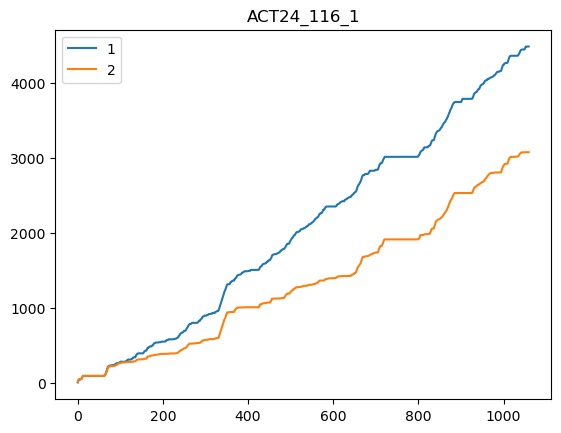

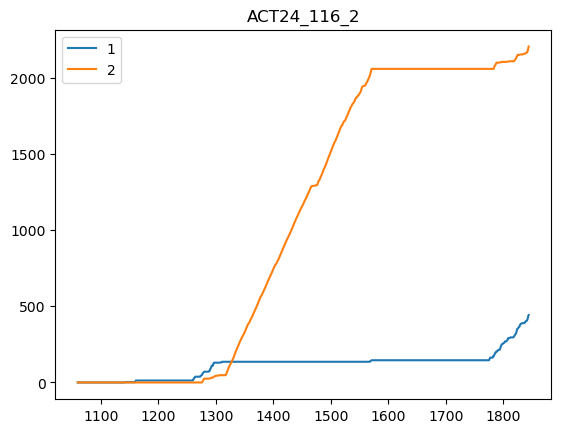

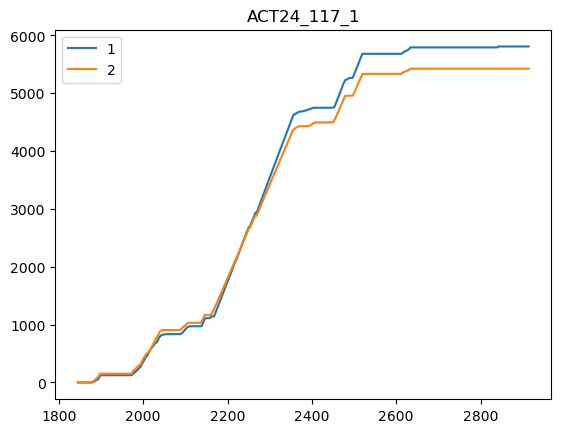

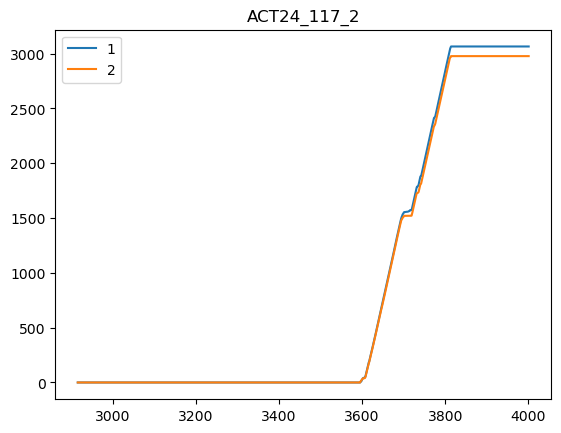

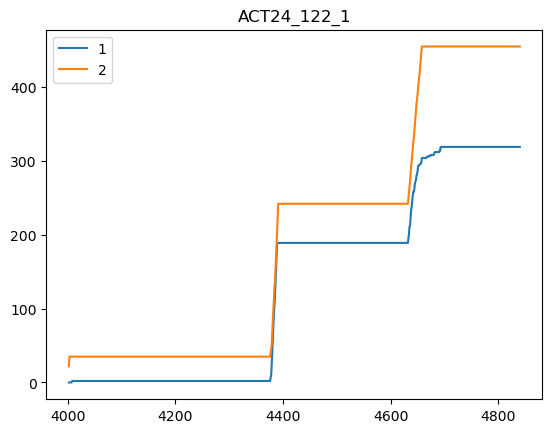

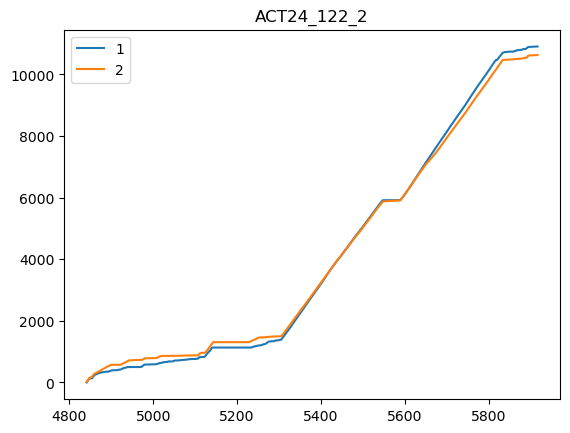

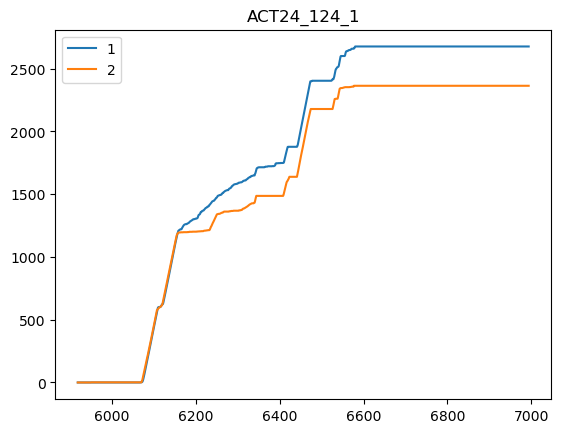

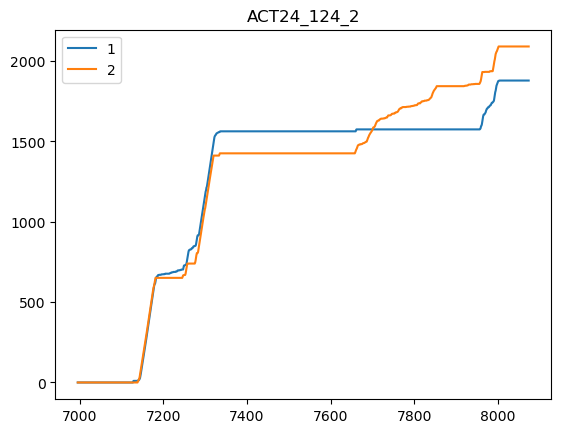

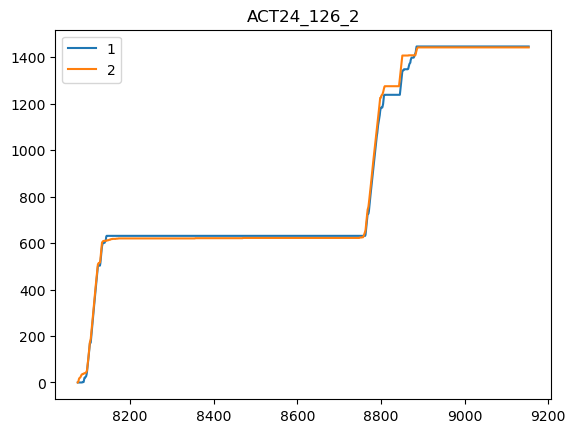

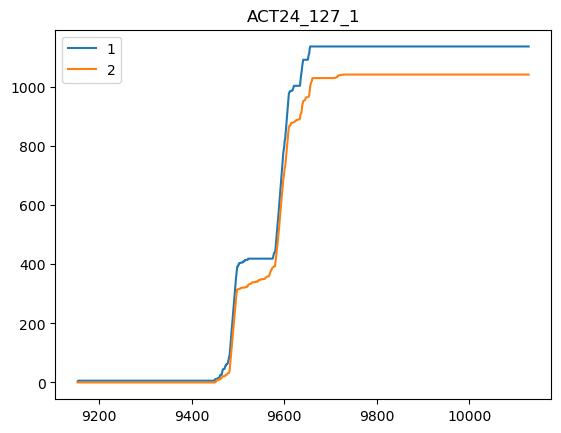

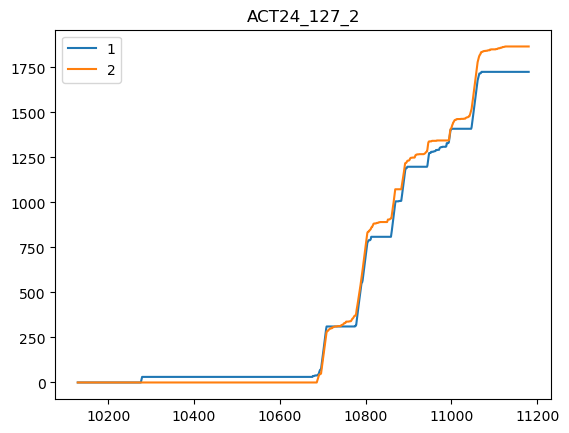

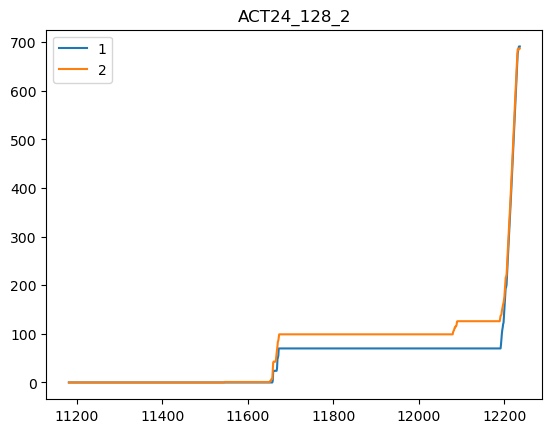

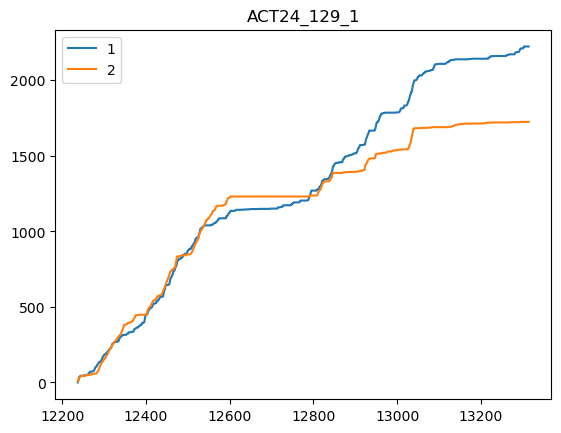

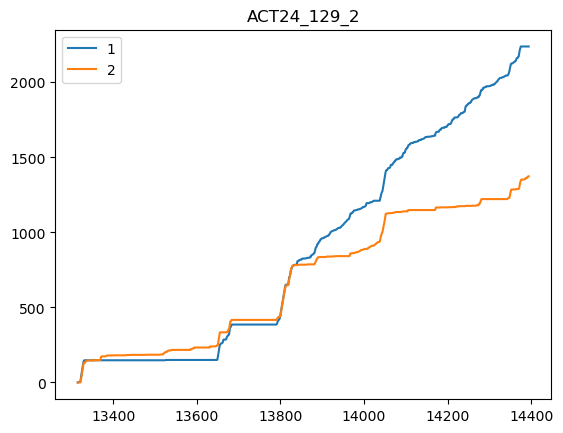

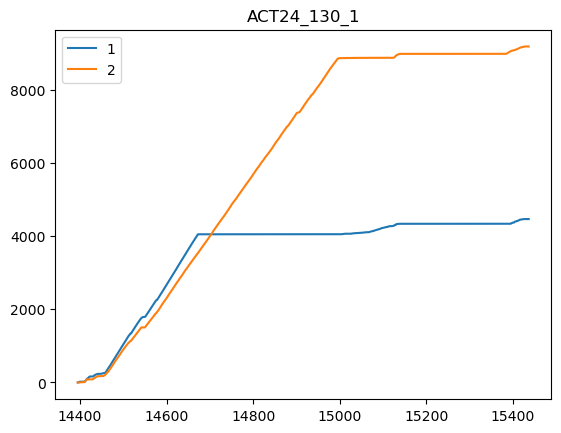

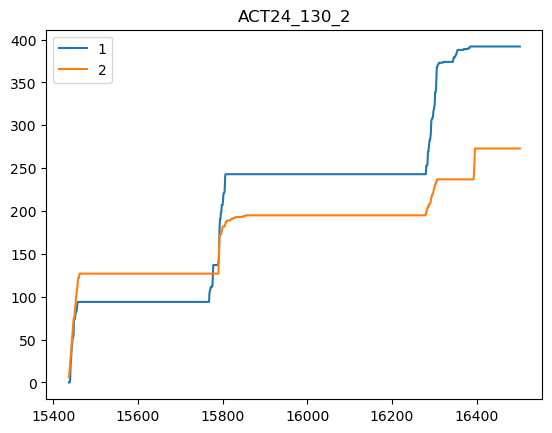

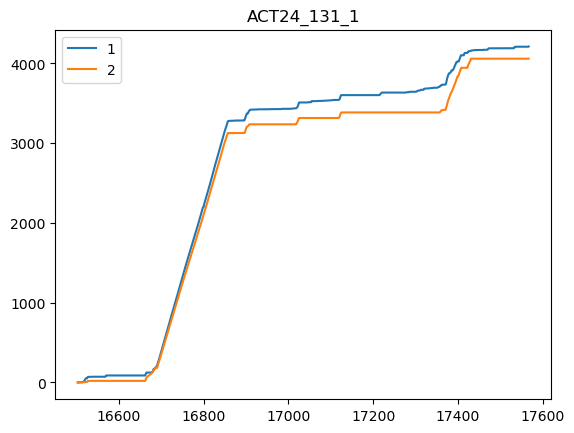

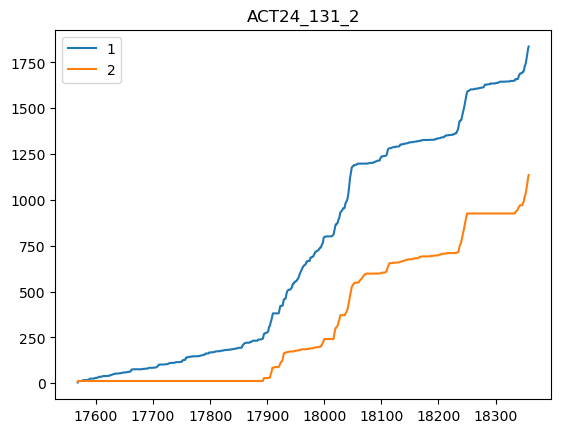

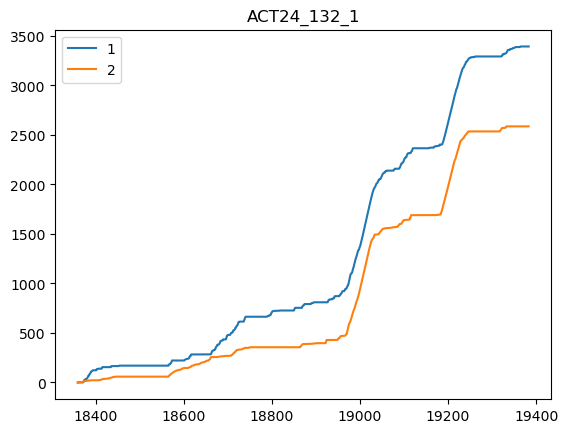

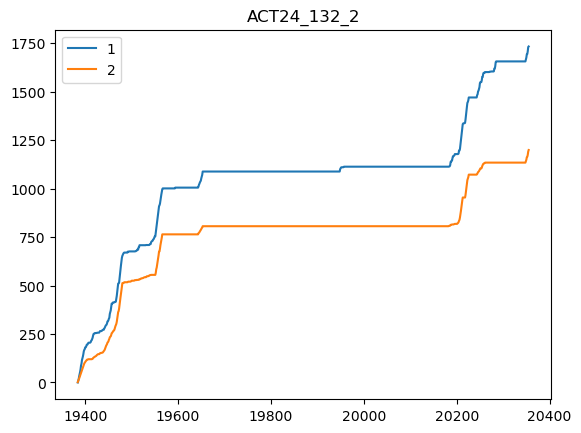

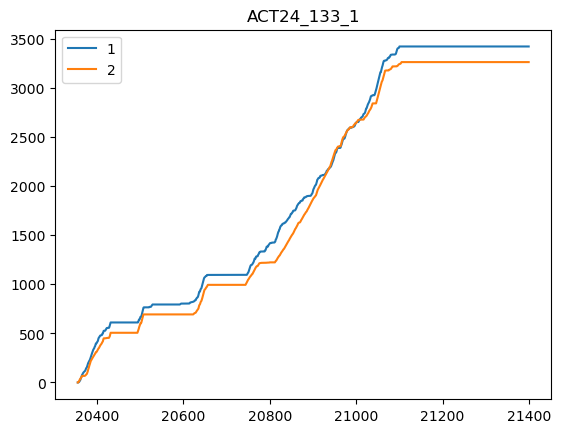

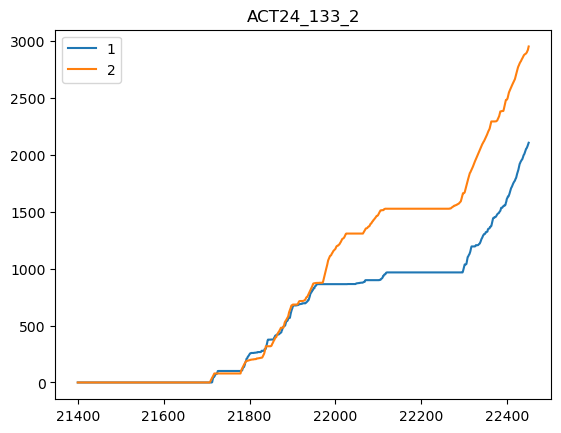

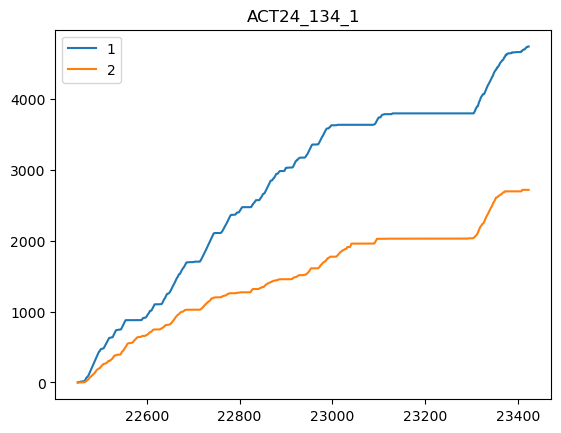

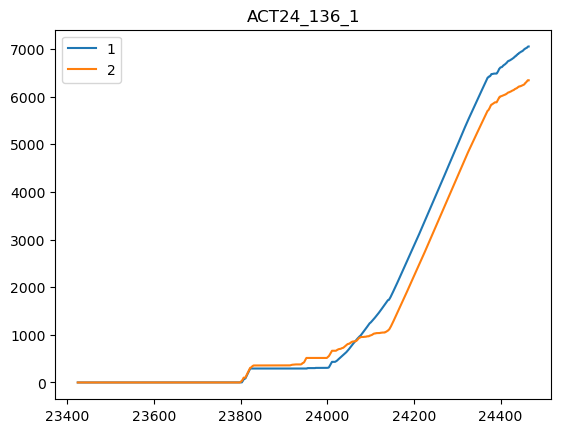

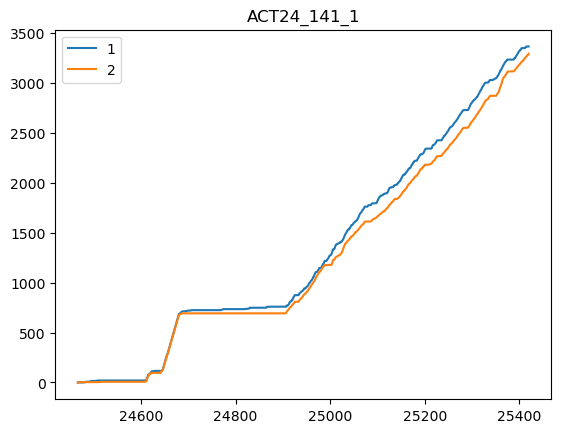

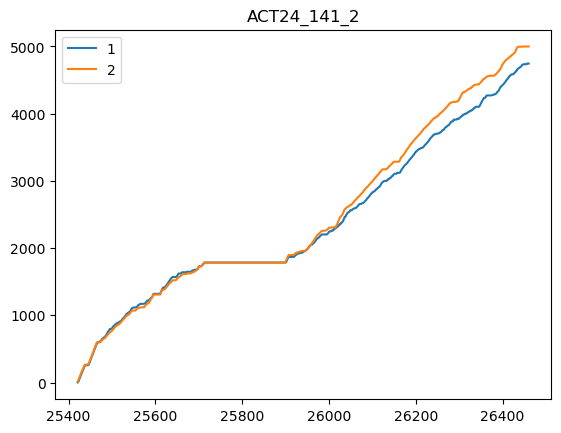

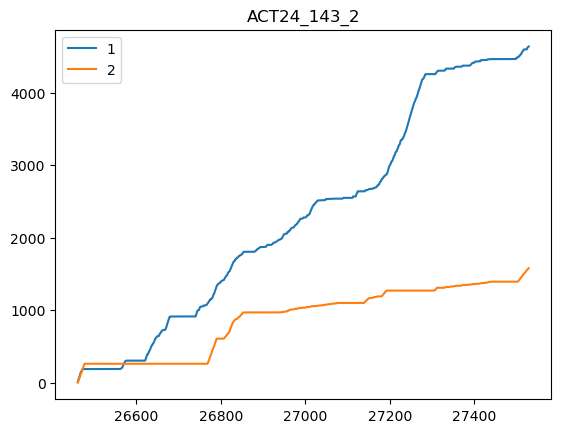

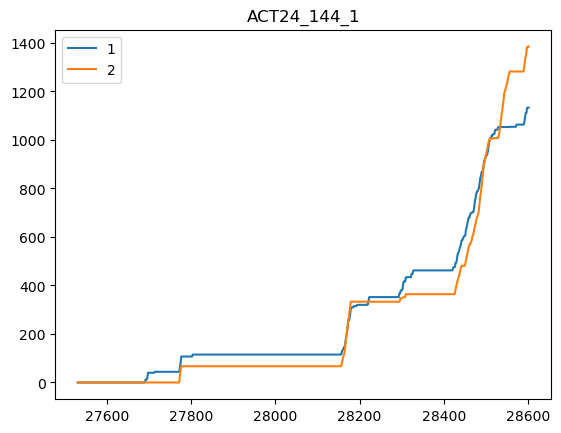

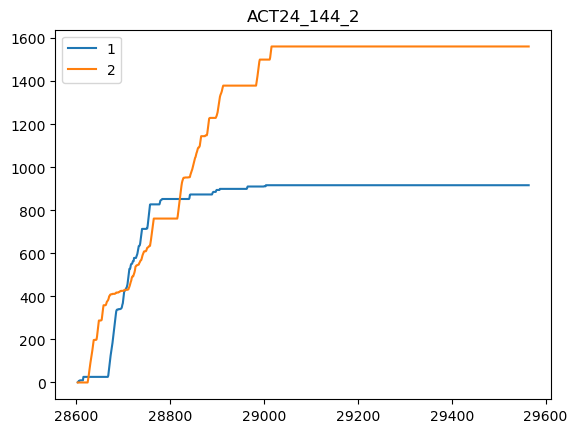

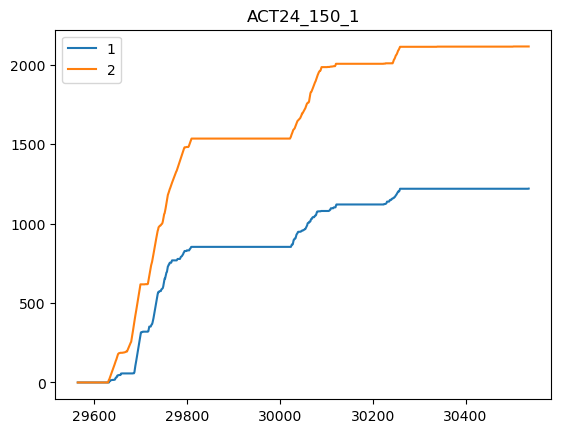

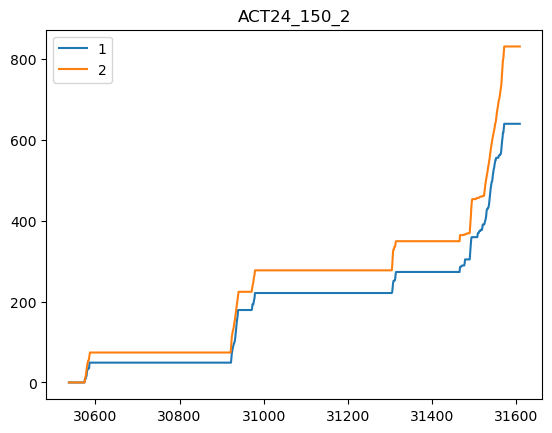

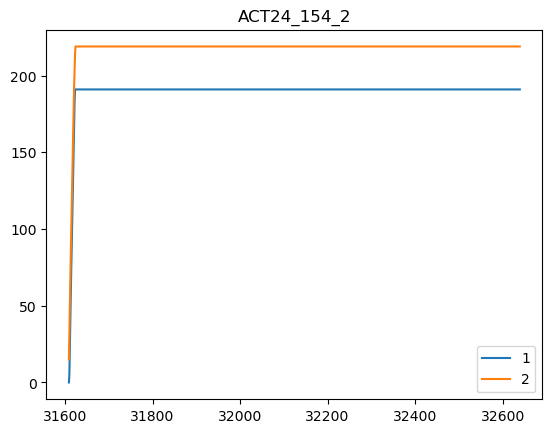

In [65]:
for g in np.unique(groups):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

Error between predicted and observed step counts, by posture:

In [66]:
pred = pd.concat([pd.Series(Y).map(num_to_posture),
                  pd.Series(Y_step), pd.Series(Yp)], axis=1)
results = pred.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
ascend stairs,1993,1101,892,0.447566
bike,0,2017,-2017,inf
descend stairs,909,986,-77,0.084708
kneeling/ squatting,527,496,31,0.058824
lying,25,11,14,0.560000
muscle strengthening,37,5,32,0.864865
other sport movement,81,11,70,0.864198
running,0,2,-2,inf
sitting,2745,3679,-934,0.340255


## Output predictions

Output predictions to .csv

In [67]:
pred_k = pd.concat([pd.Series(groups), pd.Series(T), pd.Series(Yp)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_k

,id_obs,time,pred_steps
0,ACT24_116_1,2019-08-20 08:09:05,15
1,ACT24_116_1,2019-08-20 08:09:15,17
2,ACT24_116_1,2019-08-20 08:09:25,17
3,ACT24_116_1,2019-08-20 08:09:35,2
4,ACT24_116_1,2019-08-20 08:09:45,3
...,...,...,...
32635,ACT24_154_2,2020-02-23 15:55:09,0
32636,ACT24_154_2,2020-02-23 15:55:19,0
32637,ACT24_154_2,2020-02-23 15:55:29,0
32638,ACT24_154_2,2020-02-23 15:55:39,0


In [68]:
# pred_k.to_csv("predicted_keadle_granular.csv")

## Test algorithm

Test on oxwalk dataset

In [69]:
path = './data/oxwalk_30hz_w10_o0/'

X_test = np.load(path + 'X.npy')
Y_step_test = np.load(path + 'Y_step.npy')
groups_test = np.load(path + 'groups.npy')
T_test = np.load(path + 'time.npy')

In [70]:
Yp_cat_test = wd.predict(X_test, groups_test)

Using local C:\Users\hsu_m\calpoly\data451\DATA451-Steps\stepcount\torch_hub_cache\OxWearables_ssl-wearables_v1.0.0
Classifying windows...


100%|██████████| 27/27 [00:02<00:00,  9.48it/s]


In [71]:
Yp_test = np.zeros_like(Yp_cat_test)
for label in range(1, 13):
    W = (Yp_cat_test == label)
    
    whr_walk_pred = (Yp_cat_test == label)
    Xw, Yw = X_test[whr_walk_pred], Y_step_test[whr_walk_pred]
    if len(Yw) == 0:
        continue
    Vw = toV(Xw, sample_rate, lowpass_hz)
    
    Yp_test[whr_walk_pred] = batch_count_peaks_from_V(Vw, sample_rate, find_peaks_params[label])

In [72]:
sum(Yp_test), sum(Y_step_test)

(62316, 62841)

In [73]:
preds = pd.concat([pd.Series(groups_test), pd.Series(Y_step_test), pd.Series(Yp_test)], axis=1)
results = preds.groupby(0).sum()
results['error'] = results[1] - results[2]
results['abs_per_error'] = results['error'].abs() / results[1]
results

,1,2,error,abs_per_error
0,,,,
P01,867,850,17,0.019608
P02,477,602,-125,0.262055
P03,4144,4029,115,0.027751
P04,209,127,82,0.392344
P05,528,352,176,0.333333
P06,441,560,-119,0.269841
P07,2368,2385,-17,0.007179
P08,382,181,201,0.526178
P09,431,437,-6,0.013921


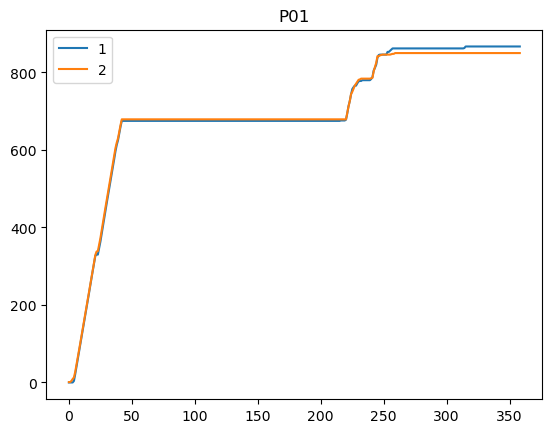

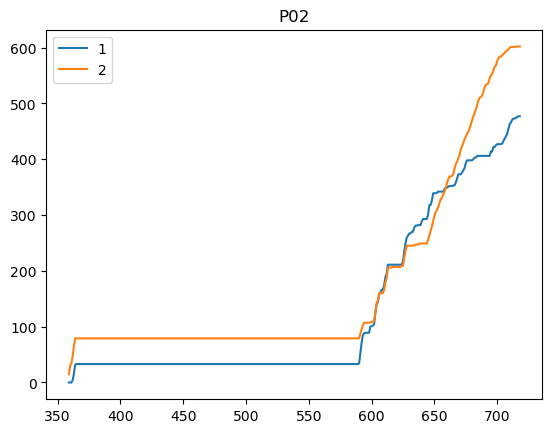

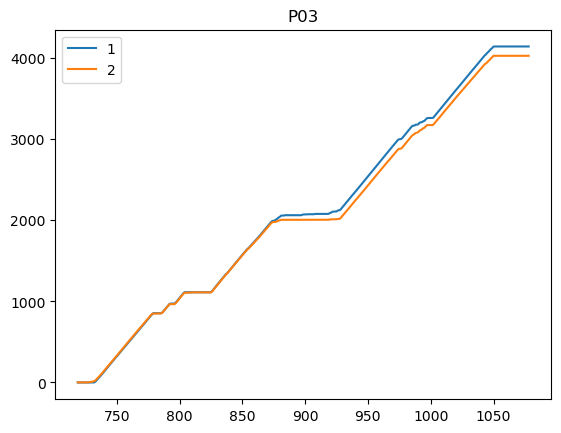

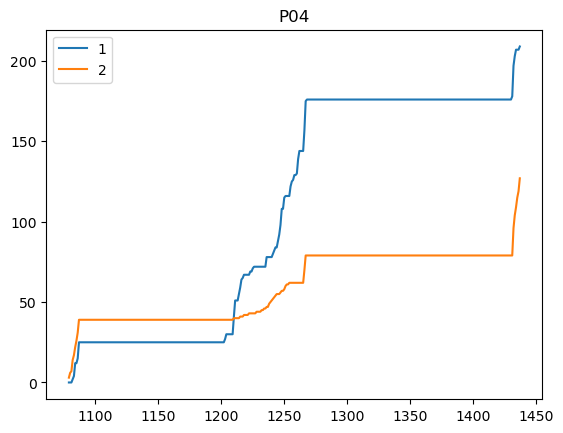

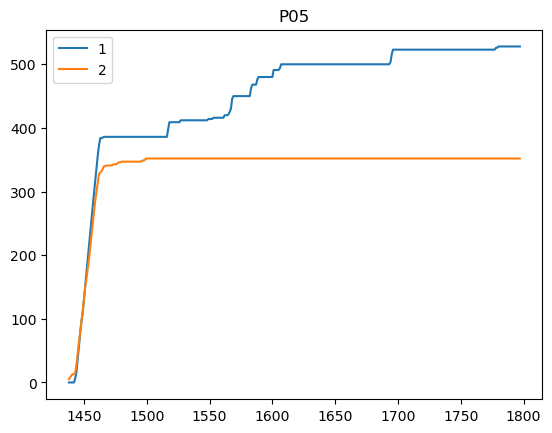

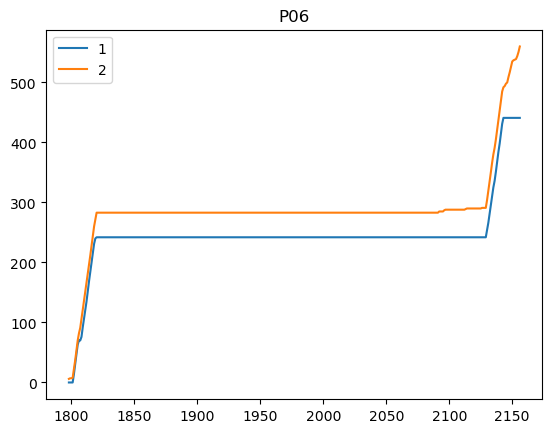

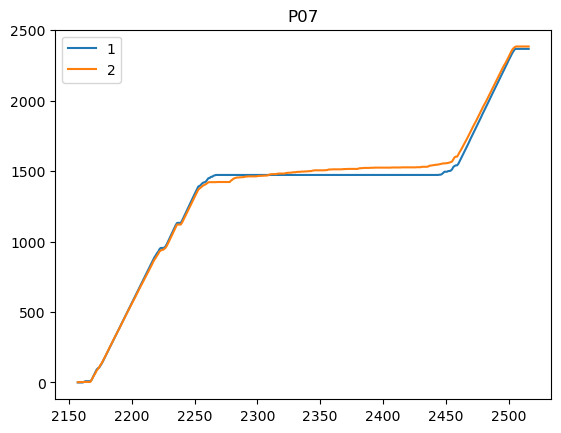

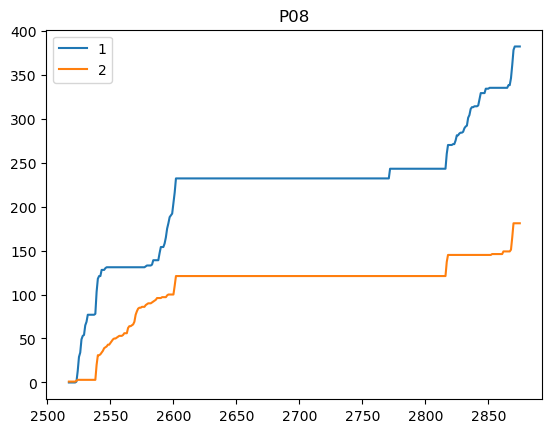

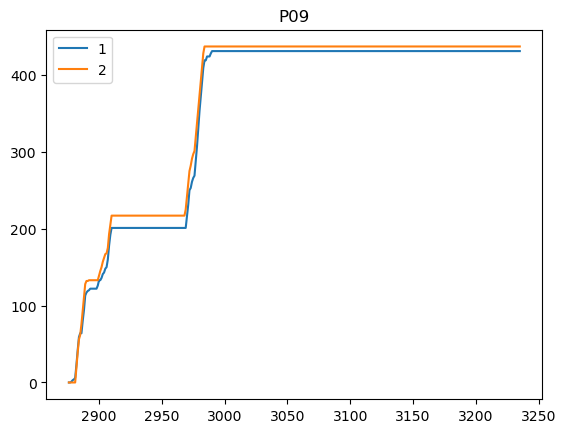

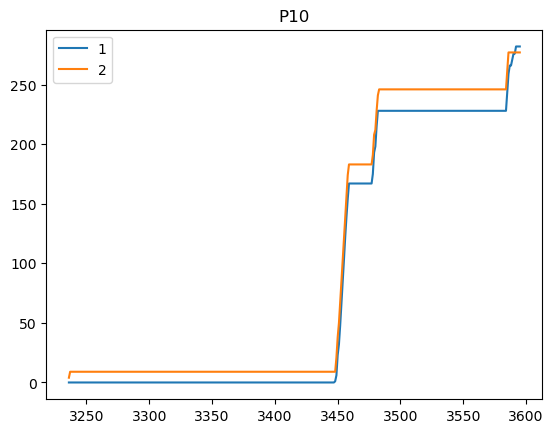

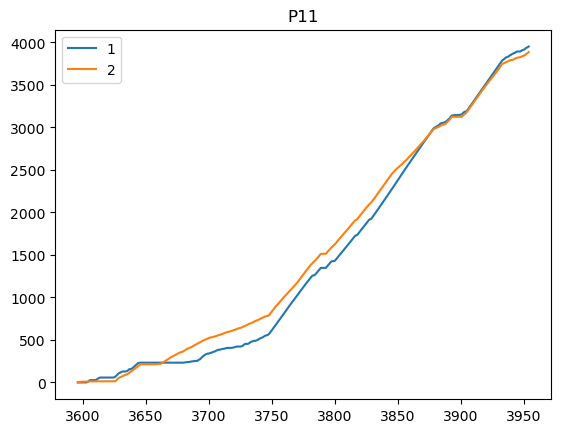

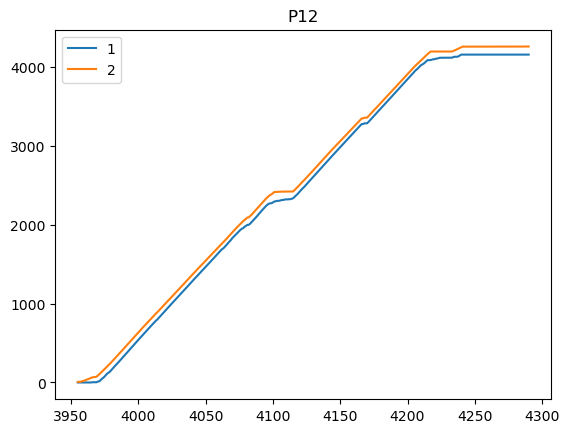

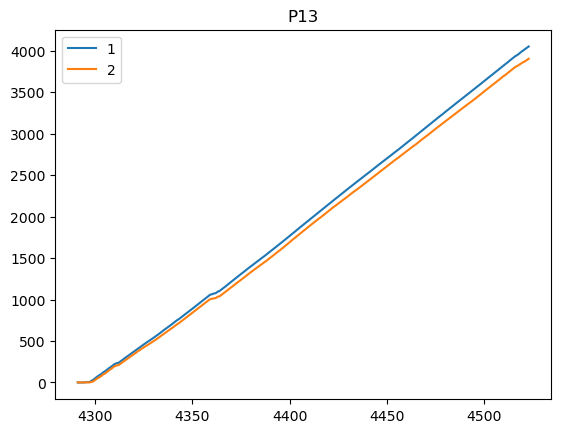

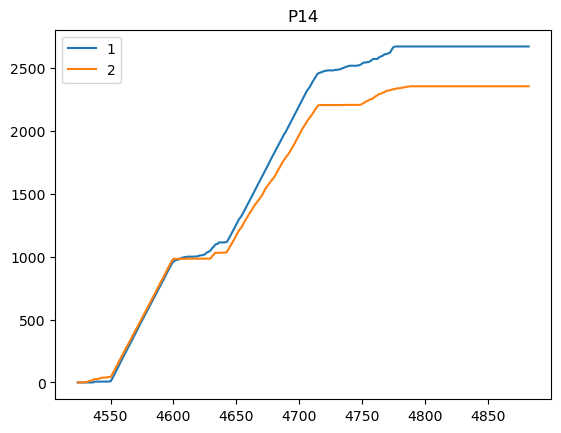

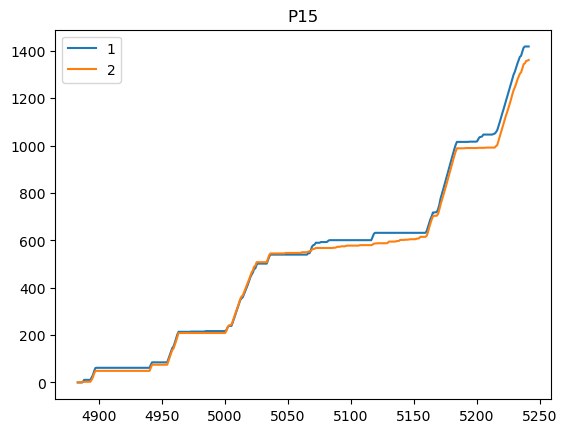

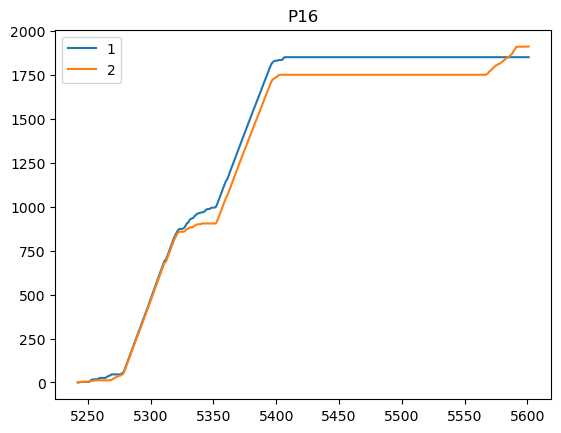

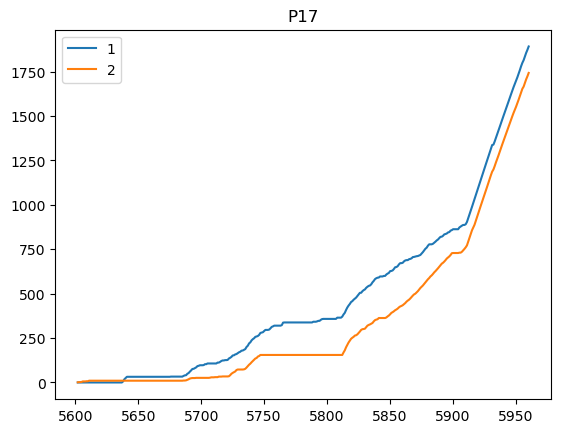

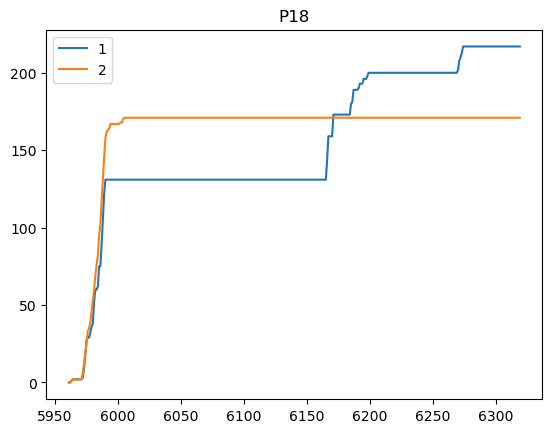

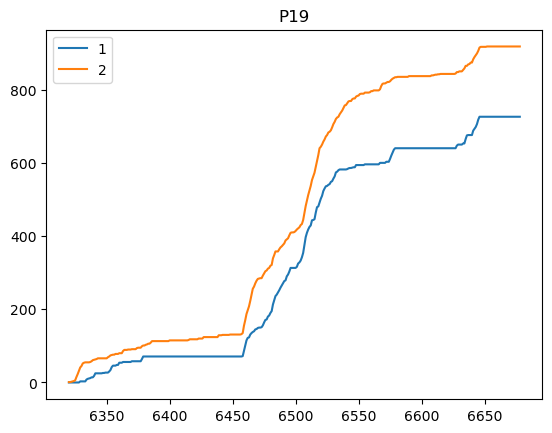

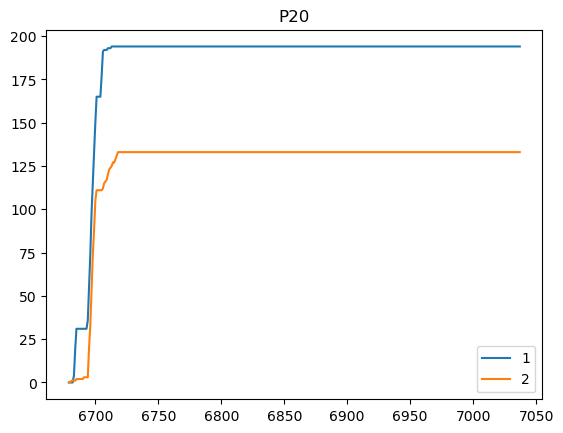

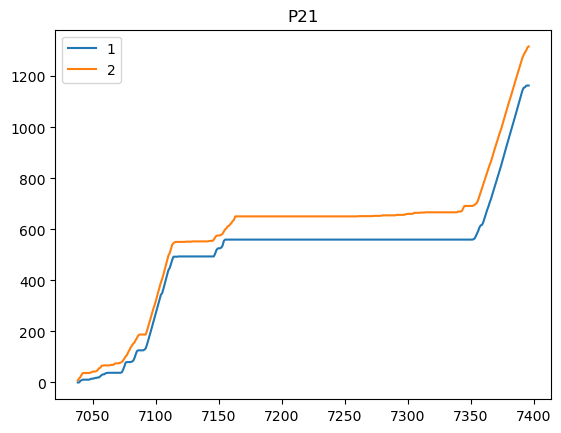

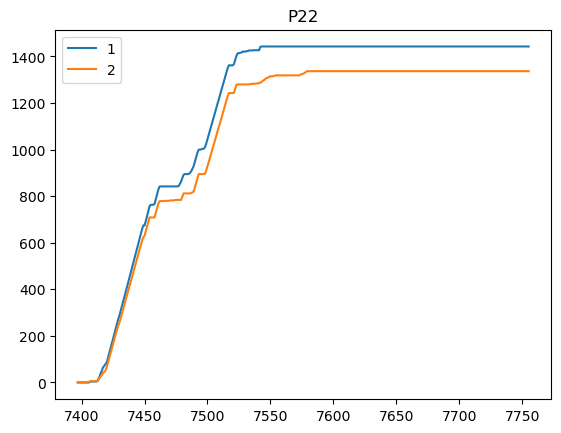

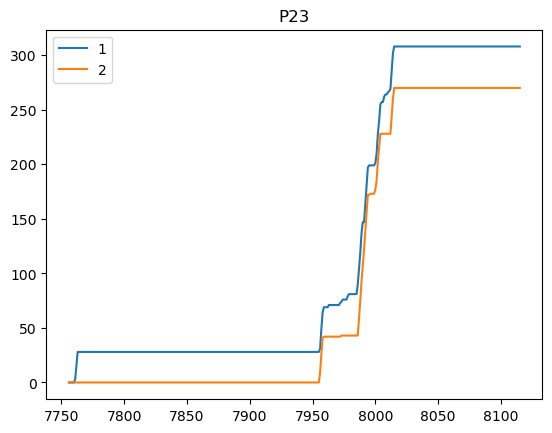

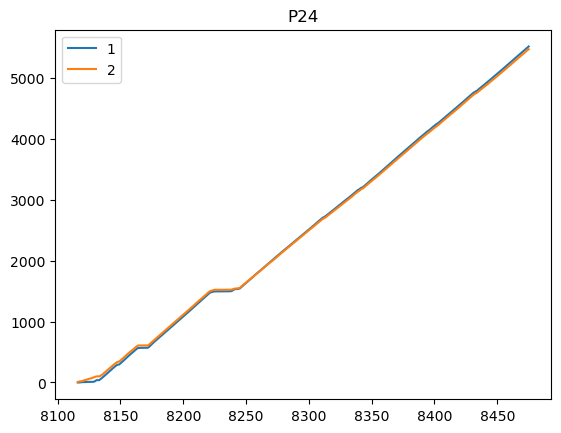

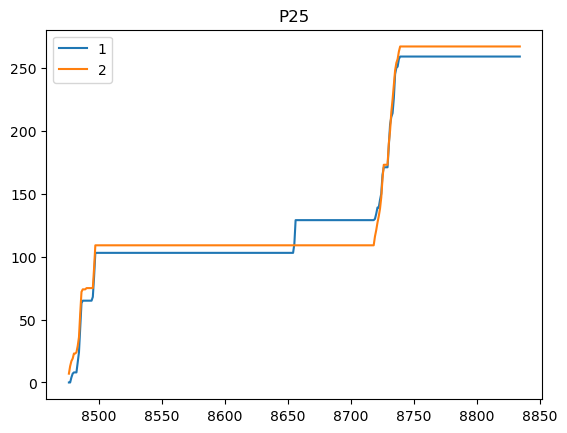

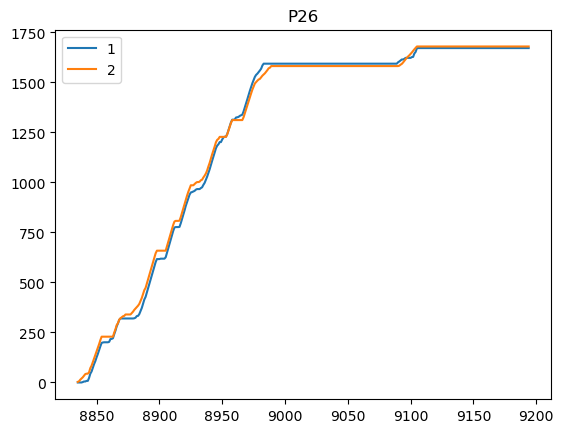

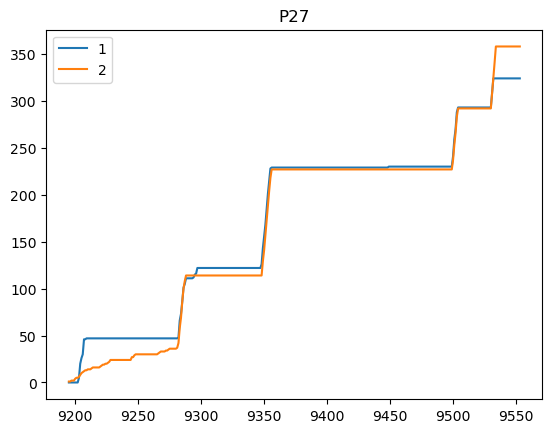

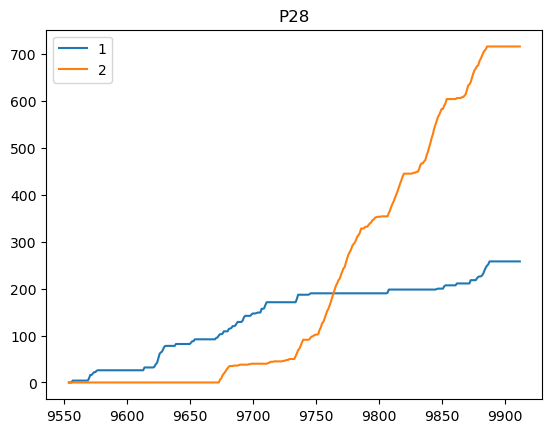

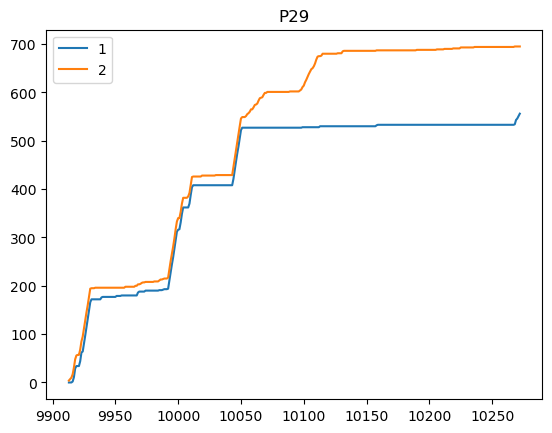

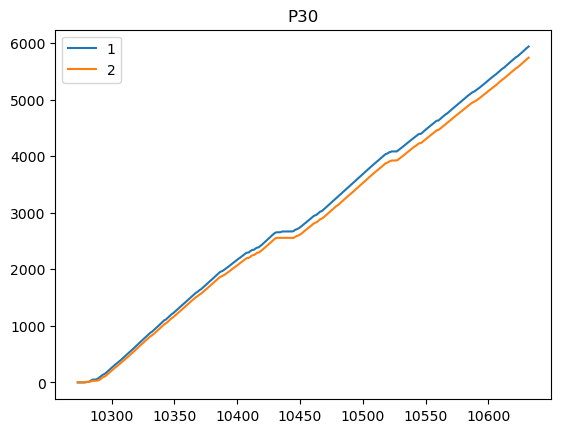

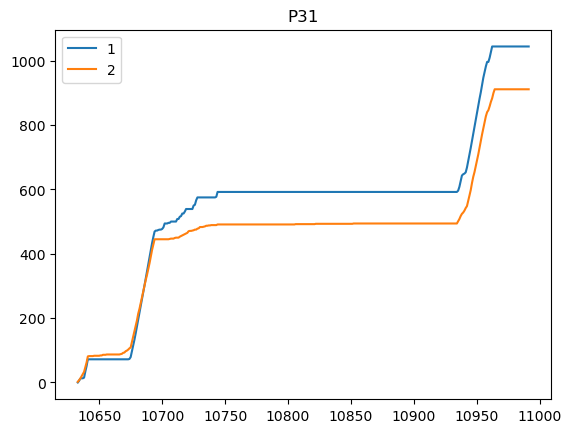

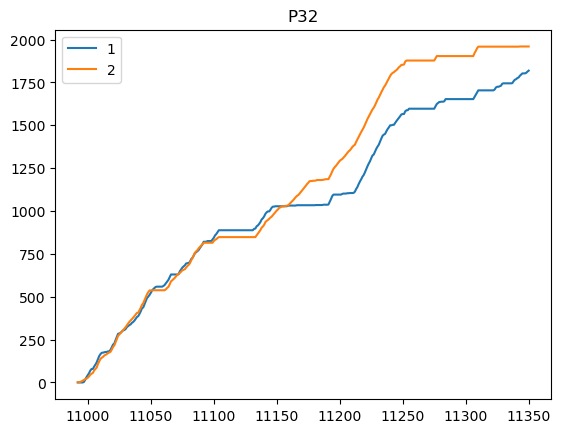

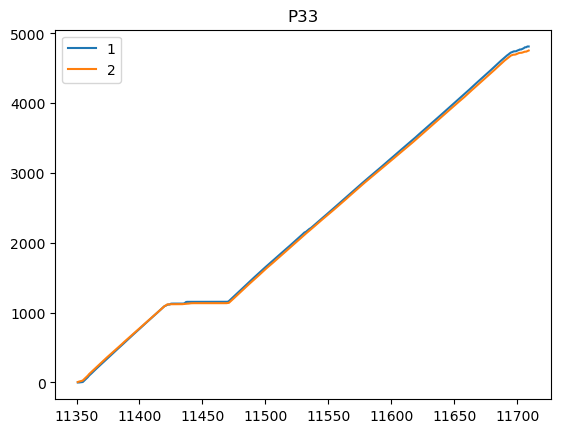

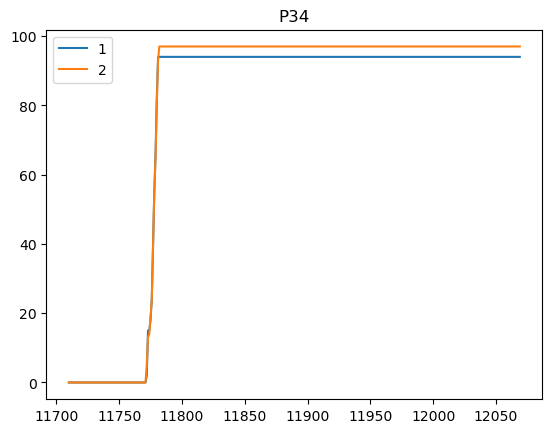

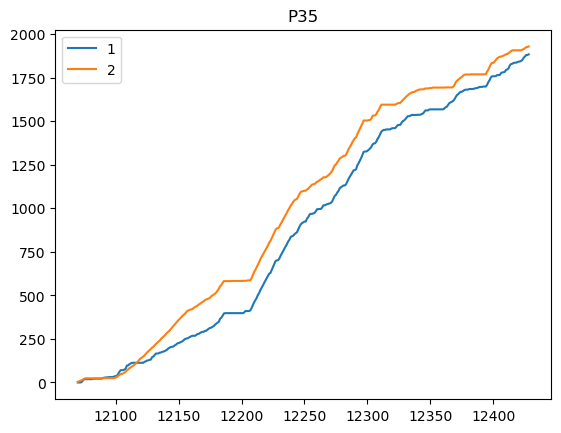

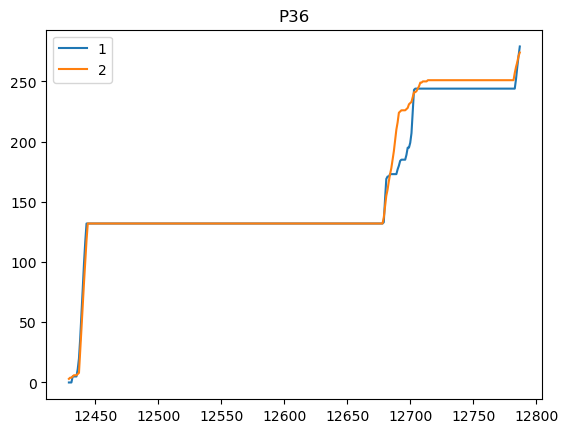

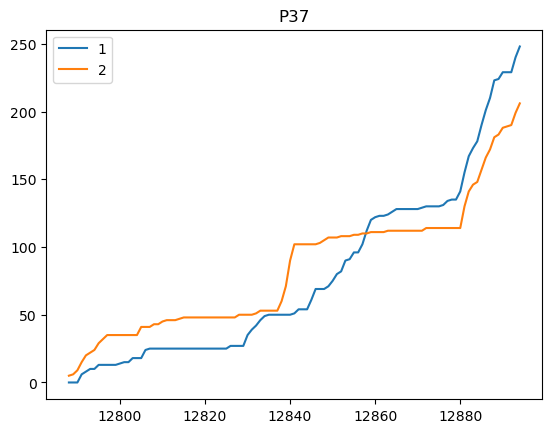

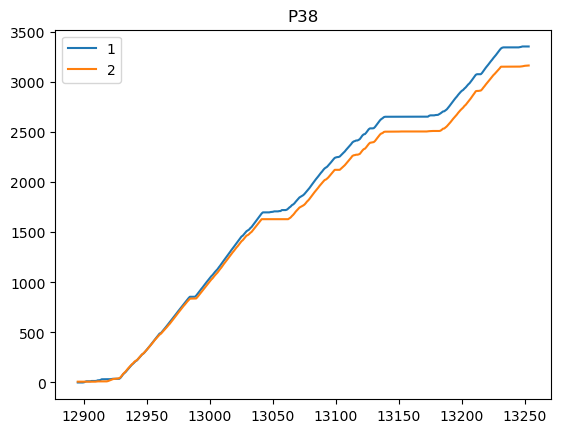

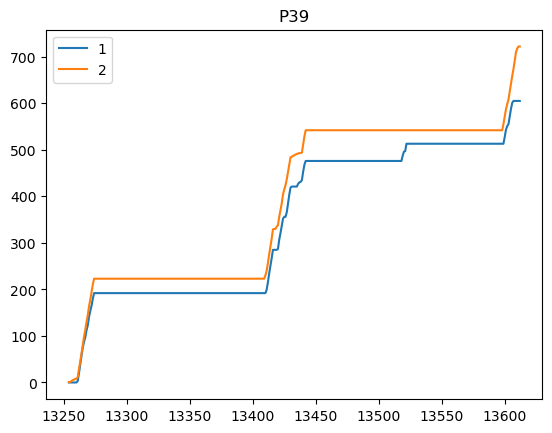

In [74]:
for g in np.unique(groups_test):
    preds[preds[0] == g][[1,2]].cumsum().plot.line()
    plt.title(g)
    plt.show()

In [75]:
pred_test = pd.concat([pd.Series(groups_test), pd.Series(T_test), pd.Series(Yp_test)], axis=1).rename(columns={0: "id_obs", 1: "time", 2: "pred_steps"})
pred_test

,id_obs,time,pred_steps
0,P01,2019-07-22 14:42:56.348,1
1,P01,2019-07-22 14:43:06.348,0
2,P01,2019-07-22 14:43:16.348,3
3,P01,2019-07-22 14:43:26.348,5
4,P01,2019-07-22 14:43:36.348,4
...,...,...,...
13608,P39,2019-07-22 14:31:52.819,18
13609,P39,2019-07-22 14:32:02.819,18
13610,P39,2019-07-22 14:32:12.819,8
13611,P39,2019-07-22 14:32:22.819,4


In [77]:
pred_test.to_csv("predicted_oxwalk_granular.csv")